**Eldar Eyvazov**


*   Student Number: 2073221
*   email address: eldar.eyvazov@studenti.unipd.it


Exam Date: 25/01/2025

Lets start by downloading script from GitHub repo

In [84]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [85]:
%%capture
get_dbn_library()

In [86]:
# import packages
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as functional
import torchvision as tv
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import math
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

from DBN import DBN

In [87]:
#choosing the device that we are going to use

print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

True
cuda


**We are going to use Fashion MNIST dataset**

This dataset consists of grayscale images (28x28 pixels) of 10 different types of clothing items.

In [88]:
#Starting by downloading the Fashion MNIST dataset
#downloading both training and test set, and test set will be used later on

fashion_train = tv.datasets.FashionMNIST('data/', train=True, download=True,
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]
                                                   ))

fashion_test = tv.datasets.FashionMNIST('data/', train=False, download=True,
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]
                                                   ))

# Exploratory Analysis of Dataset

The Fashion MNIST dataset is a widely used benchmark in computer vision and machine learning. It replaces the traditional MNIST dataset, focusing on classifying images of clothing items rather than handwritten digits. With 60,000 training images and 10,000 testing images, each 28x28 pixels, it includes categories like t-shirts, trousers, pullovers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots. This dataset is valuable for developing algorithms and models for image recognition in the fashion domain. In our case, we use it to compare the performance of Deep Belief Networks (DBNs), Feedforward Neural Networks (FFNNs), and Convolutional Neural Networks (CNNs).

In [89]:
# number of samples and shape of train and test data

train_shape = list(fashion_train.data.shape)
test_shape = list(fashion_test.data.shape)


print(f'Number of train examples: {train_shape[0]}\nShape of train:{(train_shape[1], train_shape[2])}')
print(f'Number of test examples: {test_shape[0]}\nShape of test:{(test_shape[1], test_shape[2])}\n')

# Explore the labels
print(f'We have {len(torch.unique(fashion_train.targets))} labels in the dataset:')
labels = ['T-shirt/top', # we will use this whenever we'll need the text labels
          'Trouser',
          'Pullover',
          'Dress',
          'Coat',
          'Sandal',
          'Shirt',
          'Sneaker',
          'Bag',
          'Ankle boot']
for i in range(10):
  print(f'{i+1: >2}. {labels[i]}')

Number of train examples: 60000
Shape of train:(28, 28)
Number of test examples: 10000
Shape of test:(28, 28)

We have 10 labels in the dataset:
 1. T-shirt/top
 2. Trouser
 3. Pullover
 4. Dress
 5. Coat
 6. Sandal
 7. Shirt
 8. Sneaker
 9. Bag
10. Ankle boot


In [90]:
#checking the maximum pixel values for train and test sets

fashion_train_max = fashion_train.data.type(torch.FloatTensor).max()
fashion_test_max = fashion_test.data.type(torch.FloatTensor).max()

print(f'Maximum pixel value for the train set is: {fashion_train_max}')
print(f'Maximum pixel value for the test set is: {fashion_test_max}')

Maximum pixel value for the train set is: 255.0
Maximum pixel value for the test set is: 255.0


In [91]:
#We need to do normalization, pixel values must be rescaled and have to be between 0 and 1
#So we divide by maximum pixel value 255

fashion_train.data = (fashion_train.data.type(torch.FloatTensor)/255)
fashion_test.data = (fashion_test.data.type(torch.FloatTensor)/255)

#Checking the results

fashion_train_max = fashion_train.data.type(torch.FloatTensor).max()
fashion_test_max = fashion_test.data.type(torch.FloatTensor).max()

print(f'Maximum pixel value for the train set after normalization is {fashion_train_max}')
print(f'Maximum pixel value for the test set after normalization is {fashion_test_max}')



Maximum pixel value for the train set after normalization is 1.0
Maximum pixel value for the test set after normalization is 1.0


In [92]:
#moving the data to the deive (cuda if it is available)

fashion_train.data =fashion_train.data.to(device)
fashion_test.data = fashion_test.data.to(device)
fashion_train.targets = fashion_train.targets.to(device)
fashion_test.targets = fashion_test.targets.to(device)


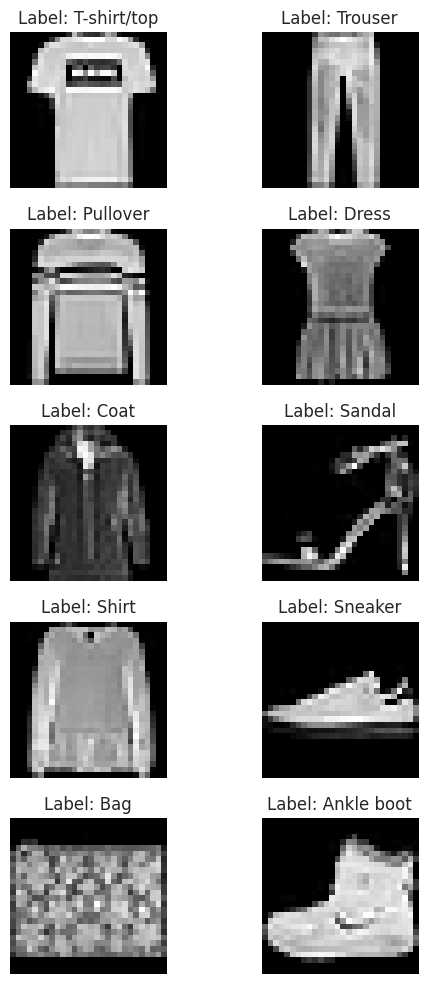

In [93]:
#using the names instead of the numbers of the labels

# use the names instead of the numbers of the labels
labels_dict = {i: name for i,name in enumerate(labels)}

def plot_samples_fashion_mnist():
    # Create a figure with a 2x5 grid
    fig, axs = plt.subplots(5, 2, figsize=(6, 10))

    # Iterate over each label (0 to 9)
    for label in range(10):
        # Find the first sample with the current label
        idx = int(torch.where(fashion_train.targets==label)[0].cpu()[0])
        sample = fashion_train.data[idx].cpu()

        # Calculate the position in the grid for the current label
        row = label // 2
        col = label % 2

        # Plot the sample image
        axs[row, col].imshow(sample.squeeze(), cmap='gray')
        axs[row, col].set_title(f'Label: {labels_dict[label]}')
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# plot a sample from each distinct class
plot_samples_fashion_mnist()

Visualizing the label distribution in the dataset

We can see that we are dealing with a perfectly balance dataset, which makes our task easier compared to unblanced datasets. In this case accuracy can be meaningful indicator of how well is our model is doing.

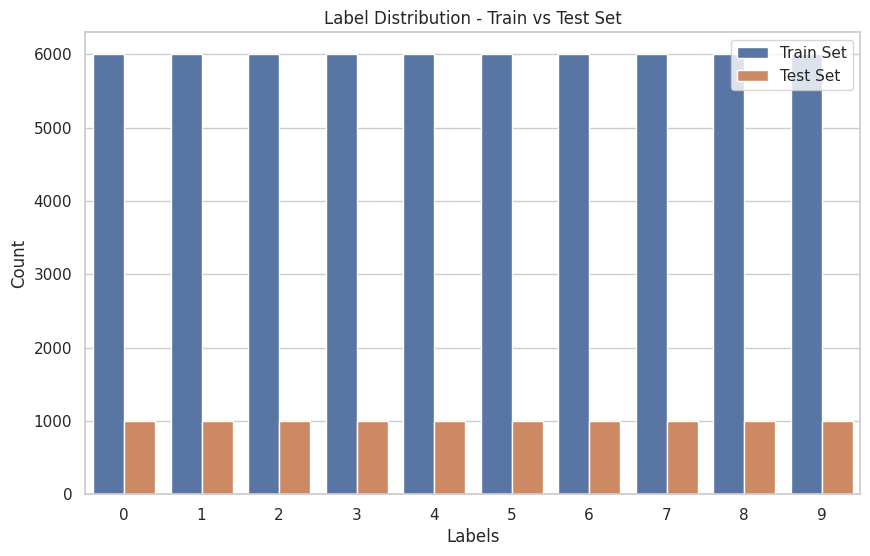

In [94]:

def label_distribution_comparison(fashion_train, fashion_test):
    # Get labels from training set
    train_labels = fashion_train.targets.cpu().numpy()
    unique_train_labels, train_label_counts = np.unique(train_labels, return_counts=True)

    # Get labels from test set
    test_labels = fashion_test.targets.cpu().numpy()
    unique_test_labels, test_label_counts = np.unique(test_labels, return_counts=True)

    # Combine the data for plotting
    data = {
        'Labels': np.concatenate([unique_train_labels, unique_test_labels]),
        'Count': np.concatenate([train_label_counts, test_label_counts]),
        'Dataset': np.concatenate([['Train Set'] * len(unique_train_labels), ['Test Set'] * len(unique_test_labels)])
    }

    # Create a bar plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Labels', y='Count', hue='Dataset', data=data)

    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Label Distribution - Train vs Test Set')
    plt.xticks(np.arange(10), labels=np.arange(10))
    plt.legend()

    plt.show()



# Now you can call the function
label_distribution_comparison(fashion_train, fashion_test)


# Deep Belief Networks

Deep Belief Networks (DBNs) are a type of artificial neural network that gained significant attention in the early development of deep learning. Composed of layers of stochastic Restricted Boltzmann Machines (RBMs), each layer serves as a hidden layer for the one above it. This hierarchical structure allows for unsupervised pre-training, where each layer learns to represent progressively intricate data features. Following pre-training, the network can undergo fine-tuning using supervised learning techniques like backpropagation. DBNs have demonstrated remarkable capabilities in tasks like feature learning, dimensionality reduction, and pattern recognition. Their strength lies in capturing complex hierarchical representations, making them well-suited for challenging datasets such as images, speech, and text.





In [95]:
hidden_units = [400, 500, 800]
dbn_fmnist  = DBN( visible_units = 28*28,
                    hidden_units = hidden_units,
                    k = 1,        # the number of iterations performed during the Gibbs sampling process
                    learning_rate = 0.09,
                    learning_rate_decay = False,
                    initial_momentum = 0.5,
                    final_momentum = 0.95,
                    weight_decay = 0.0001, # L2 regularization (weight decay to prevent overfitting)
                    xavier_init = False,
                    increase_to_cd_k = False,
                    use_gpu = torch.cuda.is_available()
                )

In [96]:


num_epochs = 80
batch_size = 128

dbn_fmnist.train_static(fashion_train.data,
                             fashion_train.targets,
                              num_epochs,
                              batch_size
                              )

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.9035     |0.0841       |295.6879   |5.4986     |
|20    |1.7659     |0.0808       |275.8956   |5.8939     |
|30    |1.7330     |0.0779       |271.6665   |5.5430     |
|40    |1.7136     |0.0774       |267.9038   |4.9175     |
|50    |1.7087     |0.0785       |268.1589   |5.3236     |
|60    |1.7036     |0.0773       |265.6178   |4.5642     |
|70    |1.6977     |0.0784       |263.9698   |4.9729     |
|80    |1.6935     |0.0771       |261.2856   |4.2499     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.1673     |0.0369       |133.4455   |2.4446     |
|20    |1.0715     |0.0339       |122.9042   |2.1505     |
|30    |1.0500     |0.0338       |119.7975   |1.9896     |
|40    |1.0413     |0.0326       |118.6422   |2.1197     |
|50    |1.0319     |0.0329       |116.9817   |1.8043     |
|60    |1.0281     |0.0341       

# Internal Representations Analysis

Analyzing the receptive fields of a Deep Belief Network (DBN) offers valuable insights into how the network learns and represents information. Receptive fields denote the areas in the input space influencing the activity of specific neurons or neuron groups. Visualizing these fields helps understand the features activating particular neurons and their spatial organization. The hierarchical feature extraction in DBNs becomes evident, with lower layers grasping low-level features like edges and textures, and higher layers capturing more intricate ones.

Moreover, the comparison of DBN's receptive fields to human learning is intriguing. The human visual system seemingly processes information hierarchically, akin to DBNs. Lower DBN layers learn simple features, analogous to the initial stages of human visual processing, eventually combining them in higher layers for more complex representations. This alignment implies that DBNs encapsulate fundamental principles of visual learning, presenting a computational framework consistent with human perception and cognition mechanisms.


In [97]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

def plot_layer_receptive_fields(weights, layer):
  num_subplots = 100 # 7x7
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  fig.suptitle('Receptive fields of layer ' + str(layer), fontsize=25, y=0.95)
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

In [98]:
learned_weights_layer_1    = get_weights(dbn_fmnist, layer=0)
learned_weights_layer_2    = get_weights(dbn_fmnist, layer=1)
learned_weights_layer_3    = get_weights(dbn_fmnist, layer=2)

learned_weights_12_product = (learned_weights_layer_1    @ learned_weights_layer_2)  # Here we do the projection
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3) # Here we do the projection

learned_weights_layer_1    = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_12_product = apply_threshold(learned_weights_12_product, 0.1)
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)

learned_weights_layer_1    = apply_min_max_scaler(learned_weights_layer_1)
learned_weights_12_product = apply_min_max_scaler(learned_weights_12_product)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)


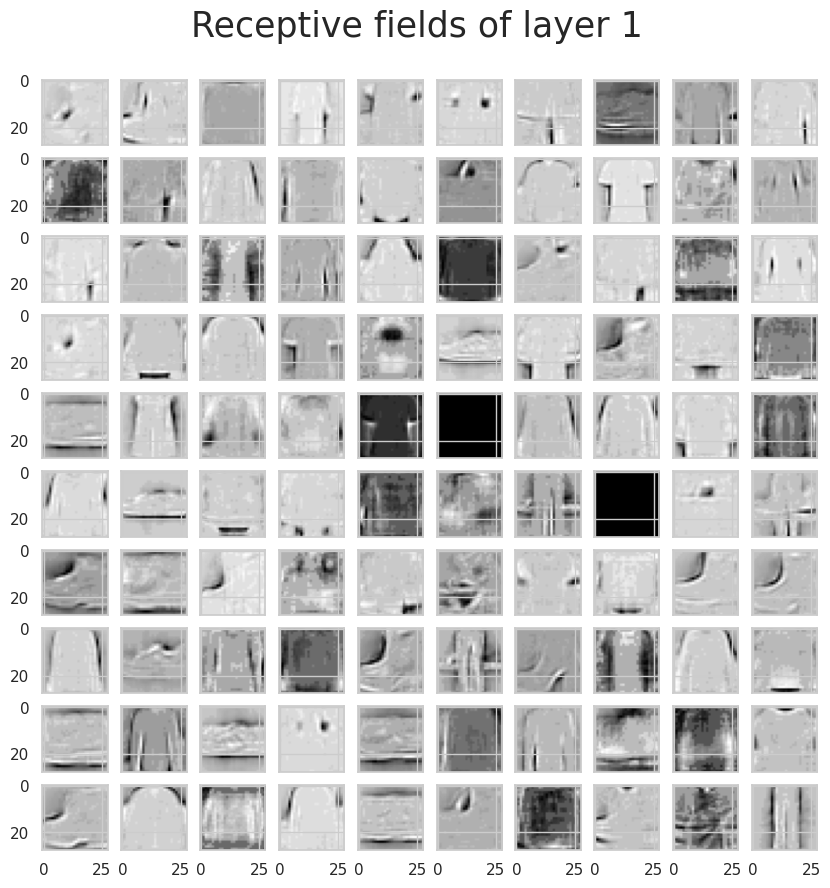

In [99]:
plot_layer_receptive_fields(learned_weights_layer_1.T, 1)

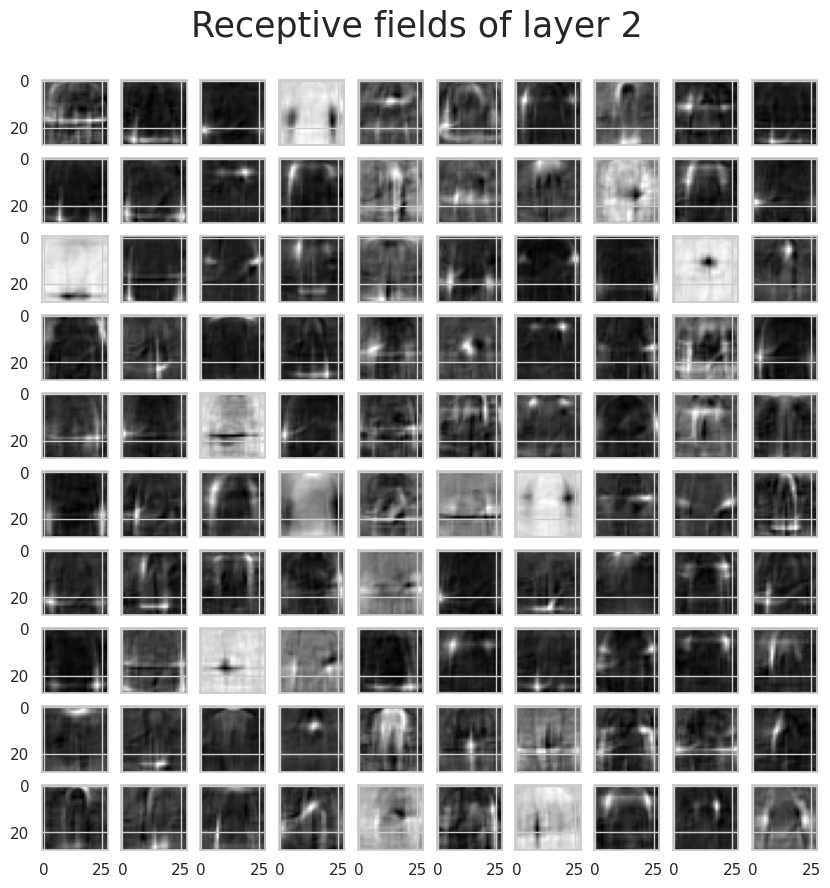

In [100]:
plot_layer_receptive_fields(learned_weights_12_product.T, 2)

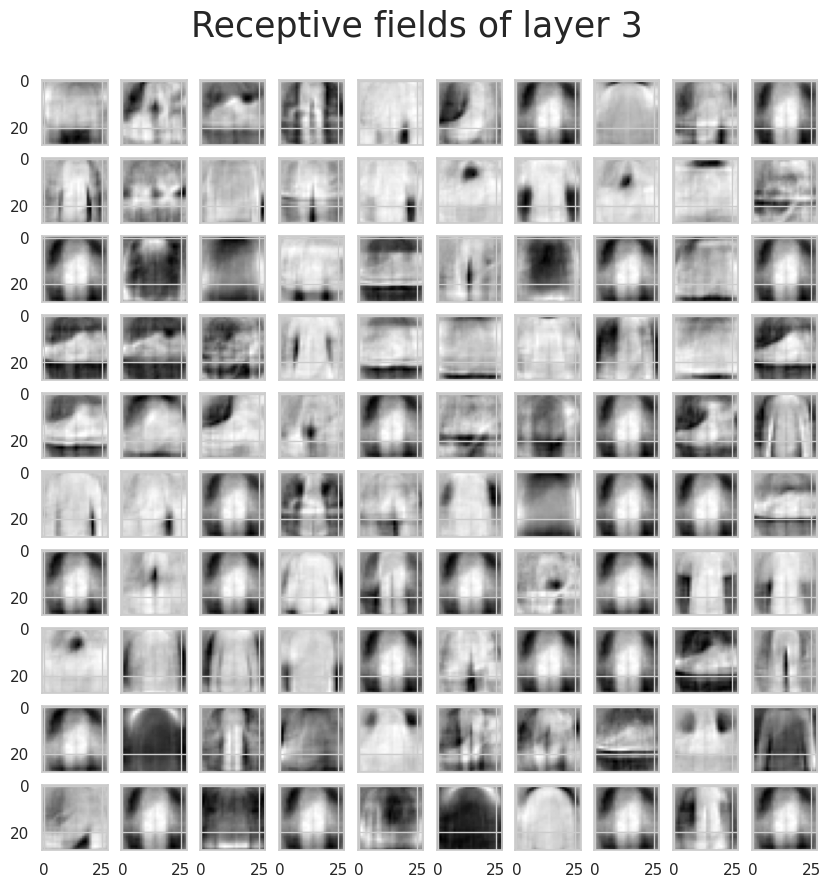

In [101]:
plot_layer_receptive_fields(learned_weights_23_product.T, 3)

In [102]:
def get_kth_layer_repr(input, k, device, dbn_fashionmnist):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_fashionmnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

def get_mask(label, fashion_train):  # we use this function to filter by class
  labels = fashion_train.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation, fashion_train):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label, fashion_train)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(len(set(fashion_train.targets.cpu().numpy())))
  }

def get_hidden_reprs_matrix(hidden_representation, fashion_train):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation, fashion_train)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(len(set(fashion_train.targets.cpu().numpy())))])

def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax    = plt.subplots(figsize=(12,6))
  linkage    = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

  x_tick_labels     = ax.get_xticklabels()                               # Get the x-axis tick labels
  x_ticks           = [int(label.get_text()) for label in x_tick_labels] # Extract the text of each tick label
  new_x_tick_labels = [labels[i] for i in x_ticks]       # Change the x-axis tick labels
  ax.set_xticklabels(new_x_tick_labels)

In [103]:
hidden_repr_layer_1 = get_kth_layer_repr(fashion_train.data, 0, device, dbn_fmnist)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device, dbn_fmnist)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device, dbn_fmnist)

mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_layer_1, fashion_train)
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_layer_2, fashion_train)
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3, fashion_train)

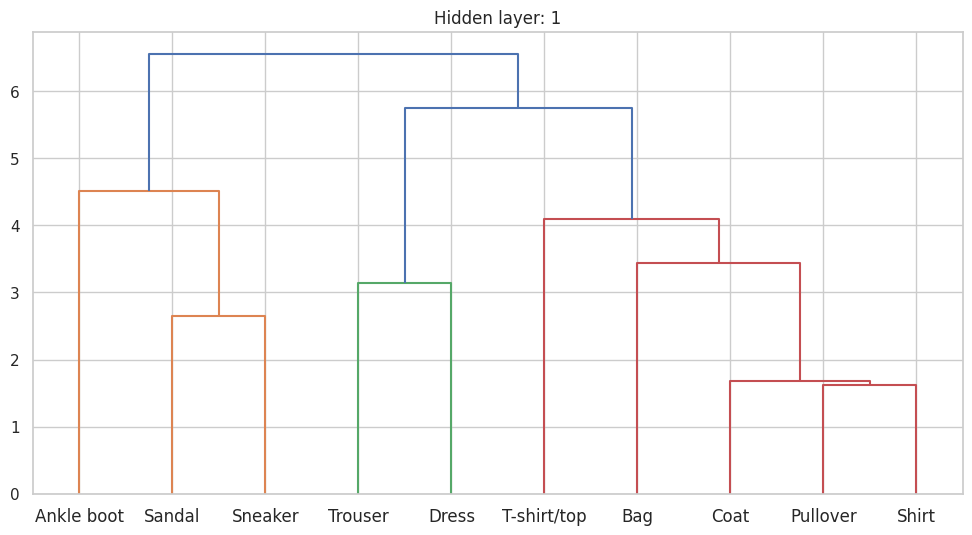

In [104]:
plot_dendrogram(mean_hidd_repr_matrix_1, f"Hidden layer: {1}")

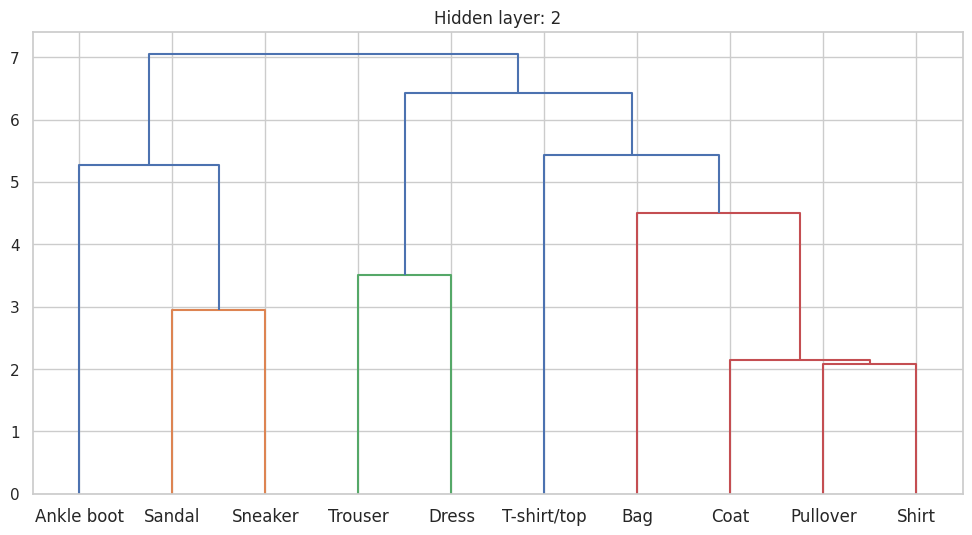

In [105]:
plot_dendrogram(mean_hidd_repr_matrix_2, f"Hidden layer: {2}")

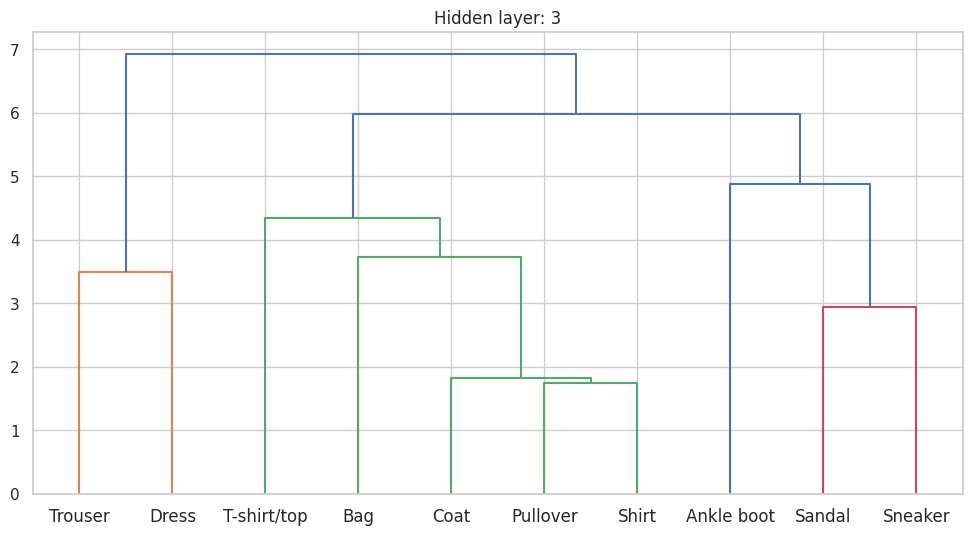

In [106]:
plot_dendrogram(mean_hidd_repr_matrix_3, f"Hidden layer: {3}")

To comprehend the semantic meaning embedded in the data representation learned by our Deep Belief Network (DBN), hierarchical clustering is employed. The resulting trees reveal impressive outcomes, showcasing the DBN's ability to capture similarities between distinct classes. Notably, clothing items with analogous features cluster together effectively. For instance, "bottom" garments like dresses and trousers form a cluster, followed by a group containing shoes (sandals, sneakers, and boots). Additionally, a separate cluster emerges for "top" clothing items, encompassing pullovers, shirts, t-shirts, coats, and bags. This successful clustering underscores the DBN's proficiency in discerning and organizing semantic relationships within the data.

# Linear read-outs


In classification tasks, integrating a Deep Belief Network (DBN) linear readout into a simple linear model proves to be an effective strategy. The linear read-outs correspond to the activations of the DBN's hidden layer neurons, capturing the high-level representations acquired during the network's hierarchical feature extraction process. By utilizing these activations in a linear model, such as logistic regression or alternatives like support vector machines or K-NN, the DBN's discriminative capabilities can be harnessed in an understandable manner. This approach allows for the utilization of complex and hierarchical representations learned by the DBN to classify new examples. It combines the sophisticated feature extraction of the DBN with the simplicity and interpretability of a linear model, offering a practical and efficient solution for classification tasks.





In [107]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)
  def forward(self, x):
    return self.linear(x)


def pretty_print(epoch, epochs, loss):
    bar_length = 30
    progress = int(epoch / epochs * bar_length)
    remaining = bar_length - progress

    progress_bar = '=' * progress + '>' + '.' * remaining

    print(f"Epoch: {epoch:4d}/{epochs} | Loss: {loss:.3f} [{progress_bar}]")


def train(network, input, mnist_train, epochs=1500):
  print("#####################################################################")
  print("Trainig:\n")
  optimizer = torch.optim.SGD(network.parameters(), lr=0.06)
  loss_fn   = torch.nn.CrossEntropyLoss()
  loss = []

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input)
    curr_loss = loss_fn(predictions, mnist_train.targets)
    loss.append(curr_loss.cpu().item())
    curr_loss.backward()
    optimizer.step()

    pretty_print(epoch, epochs, curr_loss)

  print('\n')

  return loss

def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy            = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [108]:
layer_size = dbn_fmnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)
loss_layer_1 = train(linear1, hidden_repr_layer_1, fashion_train)

layer_size = dbn_fmnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)
loss_layer_2 = train(linear2, hidden_repr_layer_2, fashion_train)

layer_size = dbn_fmnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)
loss_layer_3 = train(linear3, hidden_repr_layer_3, fashion_train)

#####################################################################
Trainig:

Epoch:    0/1500 | Loss: 2.347 [>..............................]
Epoch:    1/1500 | Loss: 2.288 [>..............................]
Epoch:    2/1500 | Loss: 2.232 [>..............................]
Epoch:    3/1500 | Loss: 2.179 [>..............................]
Epoch:    4/1500 | Loss: 2.128 [>..............................]
Epoch:    5/1500 | Loss: 2.080 [>..............................]
Epoch:    6/1500 | Loss: 2.034 [>..............................]
Epoch:    7/1500 | Loss: 1.990 [>..............................]
Epoch:    8/1500 | Loss: 1.949 [>..............................]
Epoch:    9/1500 | Loss: 1.909 [>..............................]
Epoch:   10/1500 | Loss: 1.872 [>..............................]
Epoch:   11/1500 | Loss: 1.836 [>..............................]
Epoch:   12/1500 | Loss: 1.801 [>..............................]
Epoch:   13/1500 | Loss: 1.769 [>..............................]
Epoch:   1

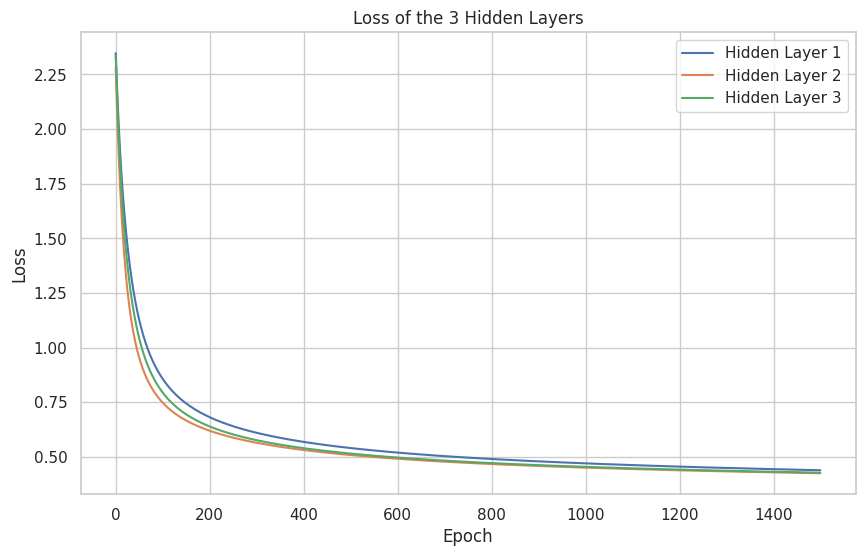

In [109]:
def visualize_loss(losses_net1, losses_net2, losses_net3):
    epochs = len(losses_net1)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), losses_net1, label='Hidden Layer 1')
    plt.plot(range(epochs), losses_net2, label='Hidden Layer 2')
    plt.plot(range(epochs), losses_net3, label='Hidden Layer 3')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss of the 3 Hidden Layers')
    plt.legend()

    plt.show()

visualize_loss(loss_layer_1, loss_layer_2, loss_layer_3)

In [110]:
hidden_repr_layer_1_test = get_kth_layer_repr(fashion_test.data, 0, device, dbn_fmnist)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device, dbn_fmnist)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device, dbn_fmnist)

# compute the predictions
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

In [111]:
layer_1_acc = compute_accuracy(predictions_test1, fashion_test.targets)
layer_2_acc = compute_accuracy(predictions_test2, fashion_test.targets)
layer_3_acc = compute_accuracy(predictions_test3, fashion_test.targets)

print(f'The accuracy of hidden layer 1 is: {layer_1_acc}')
print(f'The accuracy of hidden layer 2 is: {layer_2_acc}')
print(f'The accuracy of hidden layer 3 is: {layer_3_acc}')

The accuracy of hidden layer 1 is: 0.8375999927520752
The accuracy of hidden layer 2 is: 0.842799961566925
The accuracy of hidden layer 3 is: 0.8420000076293945


We have hidden layer with highest accuracy. However, difference is not so big.

# Comparsion with Feed Forward Neural Netwroks
Feed Forward Neural Networks (FFNNs), also known as multilayer perceptrons, serve as a foundational type of artificial neural network extensively utilized in the realms of machine learning and deep learning. Comprised of an input layer, one or more hidden layers, and an output layer, FFNNs enable the unidirectional transmission of information—from the input layer, through the hidden layers, to the output layer—earning them the label "feed forward." Within each layer, multiple artificial neurons or units execute nonlinear transformations on inputs, generating corresponding outputs. The weights governing connections between neurons dictate the strength and impact of information flow.
FFNNs showcase the capability to grasp intricate non-linear connections between inputs and outputs, making them highly effective for diverse tasks such as classification, regression, and function approximations.

In [112]:
class Feedforward(torch.nn.Module):
    def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
        super().__init__()
        self.first_hidden_layer = torch.nn.Linear(784, first_hidden_layer_size)  # 28*28 = 784
        self.second_hidden_layer = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
        self.third_hidden_layer = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
        self.output = torch.nn.Linear(third_hidden_layer_size, 10)  # 10 classes

    def forward(self, input):
        relu = torch.nn.ReLU()
        first_hidden_representation = relu(self.first_hidden_layer(input))
        second_hidden_representation = relu(self.second_hidden_layer(first_hidden_representation))
        third_hidden_representation = relu(self.third_hidden_layer(second_hidden_representation))
        output = self.output(third_hidden_representation)
        return output


In [113]:
ffnn = Feedforward(500, 500, 1000).to(device)
ffnn_loss= train(ffnn, fashion_train.data.reshape((60000, 784)),fashion_train)
prediction_ffnn=ffnn(fashion_test.data.reshape((10000,784)))
accuracy= compute_accuracy(prediction_ffnn, fashion_test.targets)

#####################################################################
Trainig:

Epoch:    0/1500 | Loss: 2.300 [>..............................]
Epoch:    1/1500 | Loss: 2.298 [>..............................]
Epoch:    2/1500 | Loss: 2.297 [>..............................]
Epoch:    3/1500 | Loss: 2.295 [>..............................]
Epoch:    4/1500 | Loss: 2.293 [>..............................]
Epoch:    5/1500 | Loss: 2.291 [>..............................]
Epoch:    6/1500 | Loss: 2.289 [>..............................]
Epoch:    7/1500 | Loss: 2.287 [>..............................]
Epoch:    8/1500 | Loss: 2.285 [>..............................]
Epoch:    9/1500 | Loss: 2.283 [>..............................]
Epoch:   10/1500 | Loss: 2.281 [>..............................]
Epoch:   11/1500 | Loss: 2.279 [>..............................]
Epoch:   12/1500 | Loss: 2.277 [>..............................]
Epoch:   13/1500 | Loss: 2.274 [>..............................]
Epoch:   1

In [114]:
print(f'Test accuracy of FFNN: {accuracy}')

Test accuracy of FFNN: 0.8362999558448792


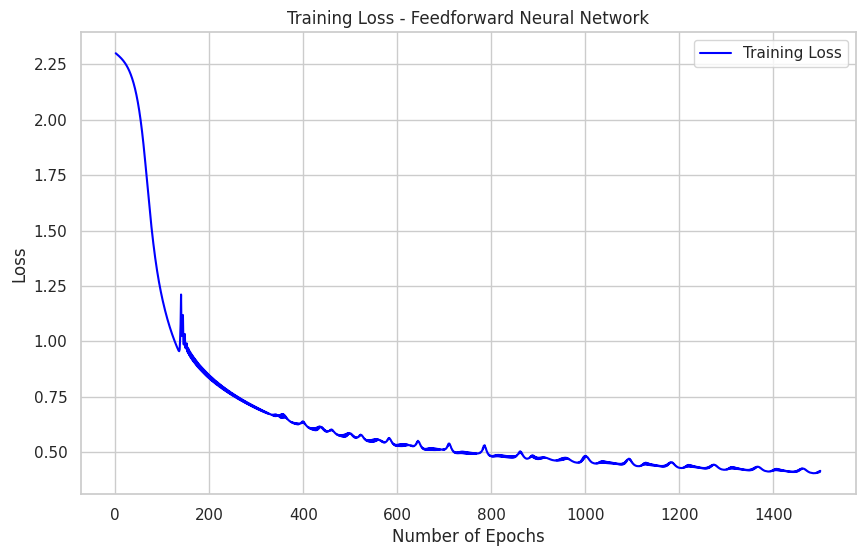

In [115]:
# Set the style
sns.set(style="whitegrid")

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(ffnn_loss) + 1), y=ffnn_loss, label='Training Loss', color='blue')

# Plot customization
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.title('Training Loss - Feedforward Neural Network')
plt.legend()

plt.show()

# Evaluation Metrics
In this section, we delve into diverse classifier metrics, aiming to pinpoint areas where models exhibit the most errors. Beyond accuracy, we leverage metrics like precision, recall, and F1 (both per class and weighted for the entire test set). The subsequent layer of analysis highlights the model with the best overall F1 score. However, a closer look at per-class scores reveals a consistent struggle across all models in correctly classifying the "Shirt" category. This class displays notably poor recall and precision, irrespective of the model under consideration.

Moving to the second segment, we visualize confusion matrices, uncovering that the "Shirt" class frequently encounters confusion with t-shirts, pullovers, and coats (all part of the same cluster in the hierarchy). There are even instances where confusion arises with dresses.



In [116]:
pred_indices_dbn1 = predictions_test1.max(axis=1).indices
pred_indices_dbn2 = predictions_test2.max(axis=1).indices
pred_indices_dbn3 = predictions_test3.max(axis=1).indices
pred_indices_ffnn = prediction_ffnn.max(axis=1).indices
predictions = {
    'dbn_layer1': pred_indices_dbn1.cpu().detach().numpy(),
    'dbn_layer2': pred_indices_dbn2.cpu().detach().numpy(),
    'dbn_layer3': pred_indices_dbn3.cpu().detach().numpy(),
    'ffnn': pred_indices_ffnn.cpu().detach().numpy(),
}



In [117]:

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from tabulate import tabulate

def scores(predictions, true_labels, labels_names):
    for model_name, model_predictions in predictions.items():
        y_pred = model_predictions

        # Per-class metrics
        precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, y_pred, average=None)
        per_class_metrics = zip(labels_names, precision, recall, f1_score)

        # Overall weighted metrics
        overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(true_labels, y_pred, average='weighted')

        # Collect results
        result_table = [["Class", "Precision", "Recall", "F1-Score"]]
        result_table += [[class_label, precision, recall, f1_score] for class_label, precision, recall, f1_score in per_class_metrics]
        result_table.append(["Overall Weighted", overall_precision, overall_recall, overall_f1])

        # Print the results using tabulate with a colorful style
        print(f"\nMetrics for {model_name}:\n")
        print(tabulate(result_table, headers="firstrow", tablefmt="fancy_grid", numalign="center", stralign="center"))
        print('\n\n')

# Assuming predictions and fashion_test.targets are defined
scores(predictions, fashion_test.targets.cpu().detach().numpy(), labels)



Metrics for dbn_layer1:

╒══════════════════╤═════════════╤══════════╤════════════╕
│      Class       │  Precision  │  Recall  │  F1-Score  │
╞══════════════════╪═════════════╪══════════╪════════════╡
│   T-shirt/top    │  0.801418   │  0.791   │  0.796175  │
├──────────────────┼─────────────┼──────────┼────────────┤
│     Trouser      │  0.990456   │  0.934   │   0.9614   │
├──────────────────┼─────────────┼──────────┼────────────┤
│     Pullover     │  0.724832   │  0.756   │  0.740088  │
├──────────────────┼─────────────┼──────────┼────────────┤
│      Dress       │  0.820246   │  0.867   │  0.842975  │
├──────────────────┼─────────────┼──────────┼────────────┤
│       Coat       │  0.747285   │  0.757   │  0.752111  │
├──────────────────┼─────────────┼──────────┼────────────┤
│      Sandal      │  0.952731   │  0.907   │  0.929303  │
├──────────────────┼─────────────┼──────────┼────────────┤
│      Shirt       │  0.610572   │  0.566   │  0.587442  │
├──────────────────┼──────────

Now lets visualize confusion matrix


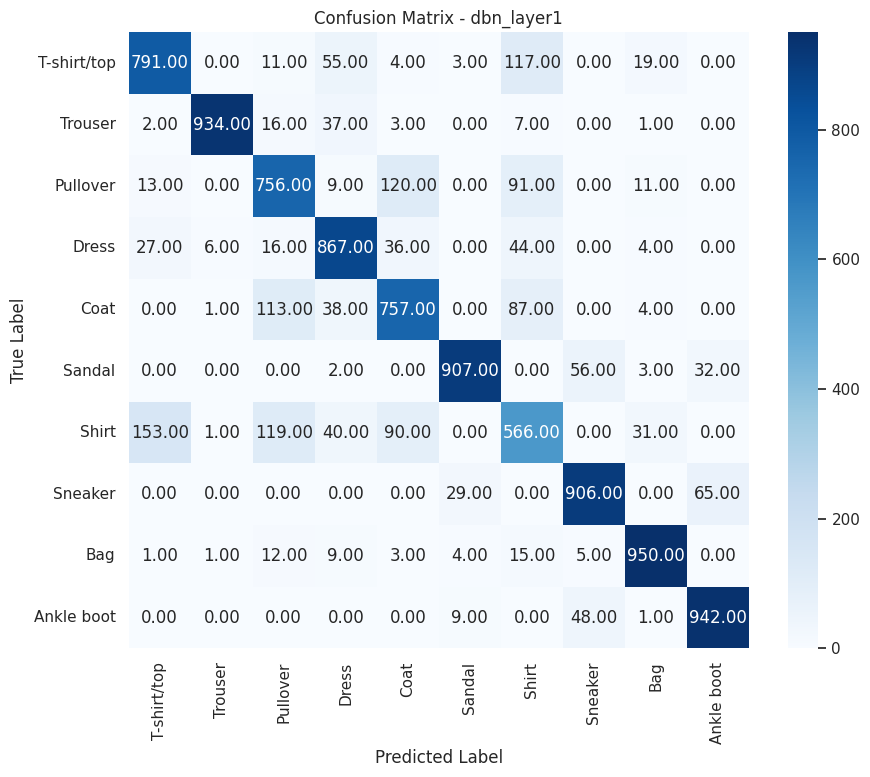

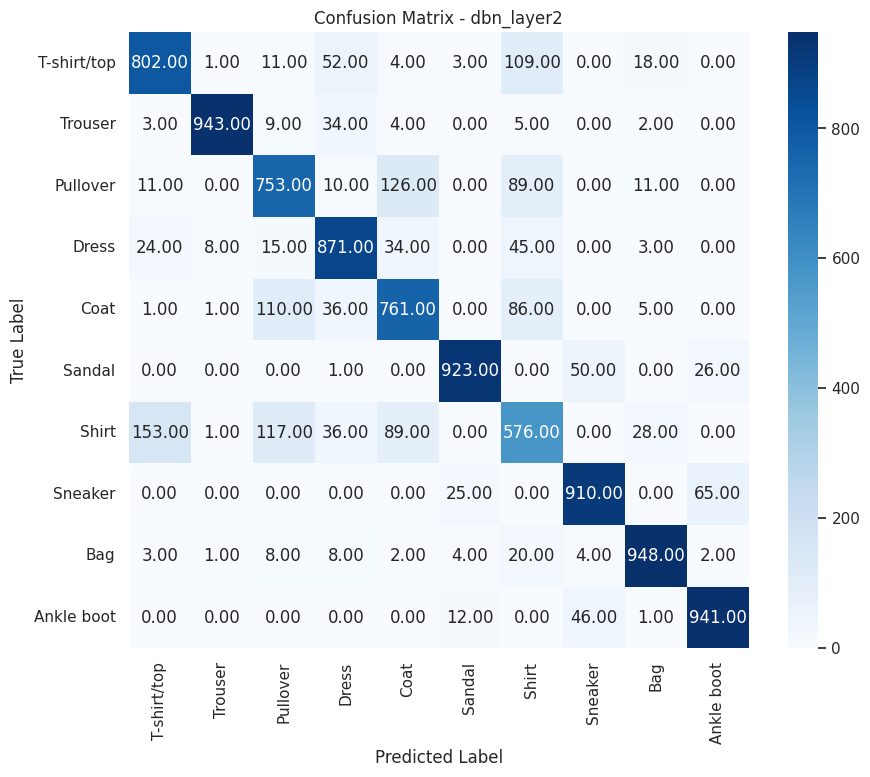

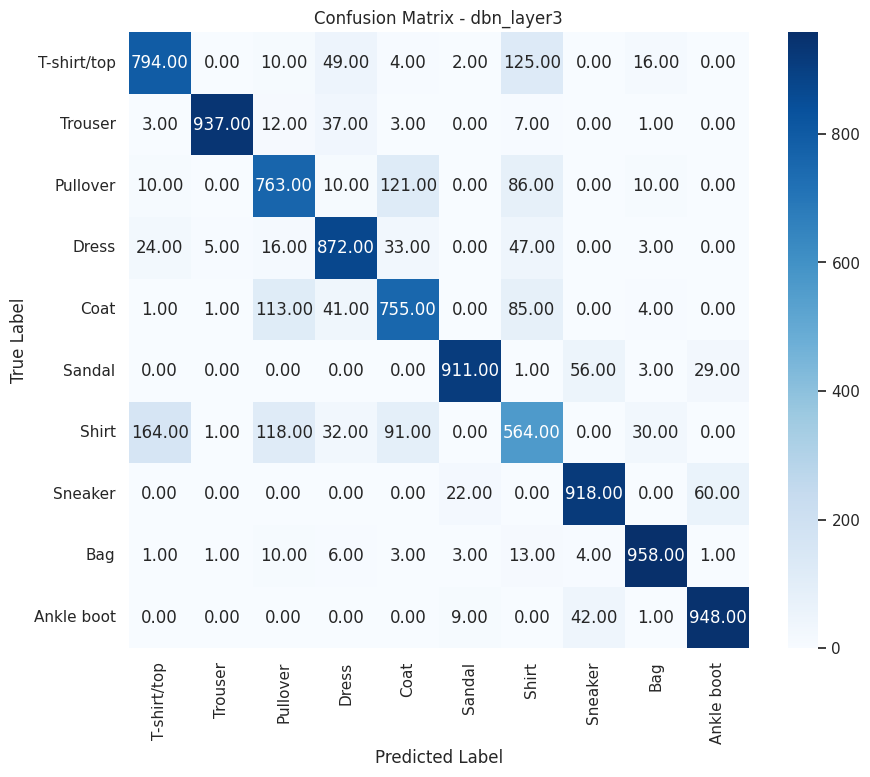

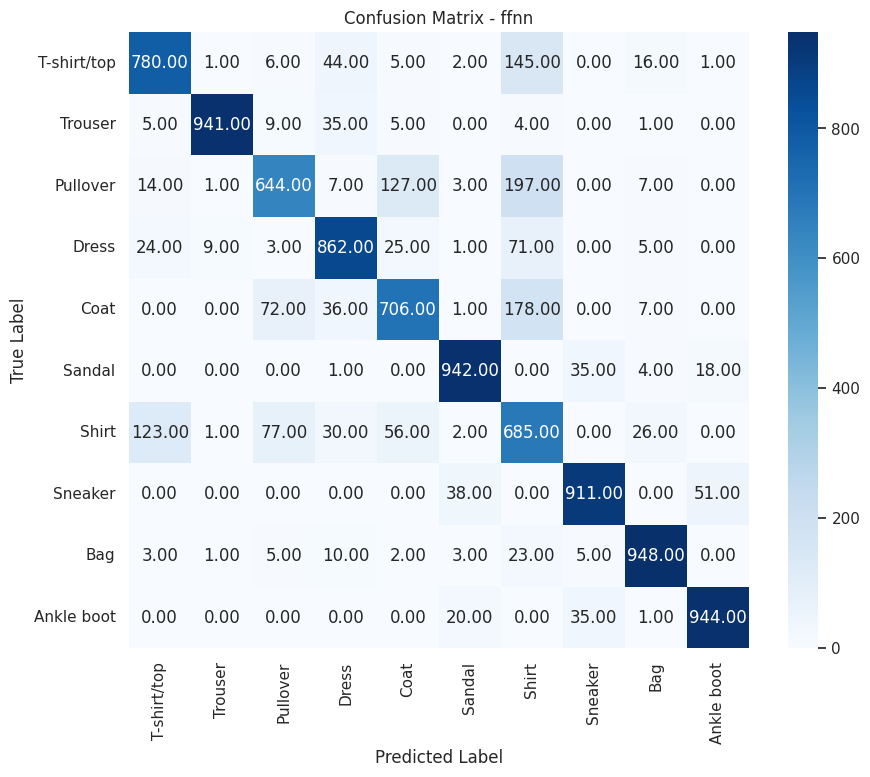

In [118]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import confusion_matrix

def plot_confusion_matrices(predictions, true_labels, labels_names):
    for model_name, model_predictions in predictions.items():
        # Compute confusion matrix
        cm = confusion_matrix(true_labels, model_predictions)



        # Create a heatmap using seaborn
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels_names, yticklabels=labels_names)
        plt.title(f"Confusion Matrix - {model_name}")
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

# Assuming predictions and fashion_test.targets are defined
plot_confusion_matrices(predictions, fashion_test.targets.cpu().detach().numpy(), labels)

# Noise Resistance

In tasks involving image classification, the resilience of a model to noise and variations becomes pivotal. Real-world images often encounter diverse sources of noise, including compression artifacts, lighting changes, occlusions, and distortions. A robust model should demonstrate the ability to accurately classify images amidst such noise and variations, ensuring consistent and reliable performance across varying conditions. This noise resilience contributes to the model's generalizability, reducing sensitivity to minor changes or irrelevant variations and minimizing the risk of misclassification.

Analyzing the final results from the Robustness to Noise plot, it becomes evident that the FFNN emerges as the least robust model in our context. Consequently, we infer that the DBN successfully extracted more meaningful latent representations from our images. Notably, the linear classifier from the 3rd state of the DBN stands out as the most stable, challenging the initial findings that slightly favored the second layer. Thus, the 3rd layer appears to be a preferable choice.



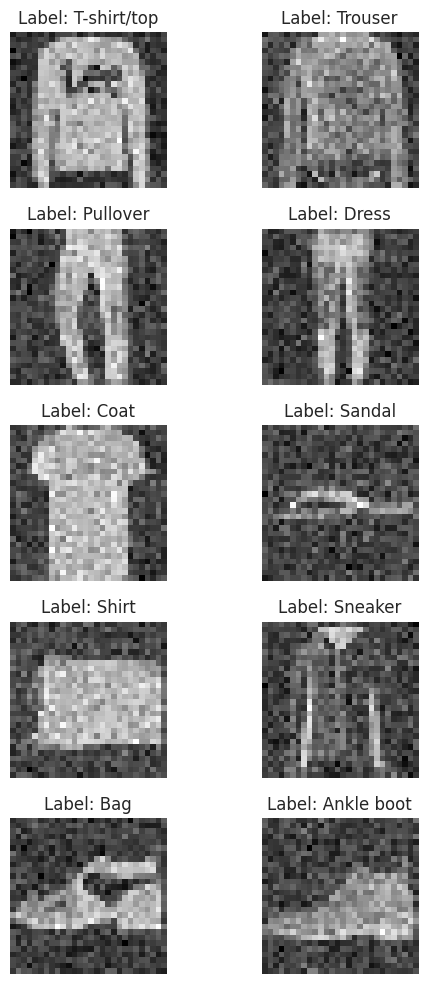

In [119]:
def noise_injection(data,noise_levels):
  return data + (noise_levels * torch.randn_like(data))
  # randn_like Returns a tensor with the same size as input that is filled
  # with random numbers from a normal distribution with mean 0 and variance 1
  # we injected Gaussian Noise

noise_levels = 0.15

fashion_test_noisy = noise_injection(fashion_test.data, noise_levels)

# using  names rather than  the numbers of  labels
labels_dict = {i: name for i,name in enumerate(labels)}

def plotting_noisy_samples():
  #figure 2x5 grid
  figure, axis = plt.subplots(5,2, figsize=(6,10))
  for label in range(10):
        # Find the first sample with the current label
        idx = int(torch.where(fashion_train.targets==label)[0].cpu()[0])
        sample = fashion_test_noisy.data[idx].cpu()

        # Calculate the position in the grid for the current label
        row = label // 2
        col = label % 2

        # Plot the sample image
        axis[row, col].imshow(sample.squeeze(), cmap='gray')
        axis[row, col].set_title(f'Label: {labels_dict[label]}')
        axis[row, col].axis('off')

  plt.tight_layout()
  plt.show()

plotting_noisy_samples()

In [120]:
def accuracy_values_at_noise_level(noise_level):
  mnist_test_with_noise = noise_injection(fashion_test.data, noise_level) # first, let's create noisy test images

  hidden_repr_layer_1_noisy = get_kth_layer_repr(mnist_test_with_noise, 0, device, dbn_fmnist)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device, dbn_fmnist)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device, dbn_fmnist)

  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)
  predictions_ffnn_noisy = ffnn(mnist_test_with_noise.reshape((10000, 784)))

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy,  fashion_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, fashion_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy,  fashion_test.targets)
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, fashion_test.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

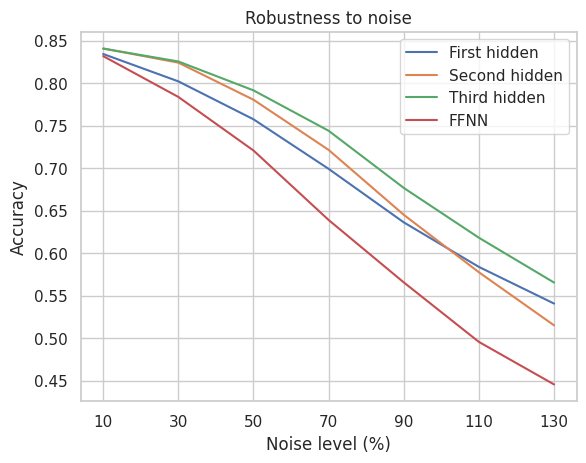

In [121]:
def noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

noise_levels = [i / 10 for i in range(1, 14, 2)]
noise_robustness_curves(noise_levels)

# Affine Transformations

This example underscores a key drawback of basic FFNNs and DBNs when handling images. When we subject images to rotation and attempt classification using these initial models, the results are significantly worse than with noise-corrupted images. The problem lies in the models' inability to capture the inherent structure of images arranged in a grid, especially when flattened into vectors.

To address this limitation, the impractical solution would be to exponentially expand the dataset, accounting for every possible variation in the object's position, size, and direction. However, this approach is neither feasible nor efficient. Even permutation of pixels in the flattened vector across examples yields identical results for simple FFNNs, despite rendering the reshaped vector back into a 2D grid nonsensical.

In contrast, Convolutional Neural Networks (CNNs) offer a more effective solution by capturing intricate dependencies in images.


In [122]:
from torchvision import transforms

def aff_transf(dataset):
  transf_data = []
  transf = transforms.RandomAffine((50, 60))
  for img in dataset:
    img_affine = transf(img.unsqueeze(0))
    transf_data.append(img_affine)
  return torch.stack(transf_data)

def accuracy_calculation_with_affine():
  data_affine = aff_transf(fashion_test.data)
  plt.imshow(data_affine[1].squeeze().to("cpu"),cmap="gray") #image with affine transformation
  plt.show()


  hidden_repr_layer_1_noisy = get_kth_layer_repr(data_affine, 0, device, dbn_fmnist)
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device, dbn_fmnist)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device, dbn_fmnist)

  predictions_first_hidden_noisy  = linear1(hidden_repr_layer_1_noisy)
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)
  predictions_ffnn_noisy = ffnn(data_affine.reshape((10000, 784)))

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, fashion_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, fashion_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, fashion_test.targets)
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, fashion_test.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn


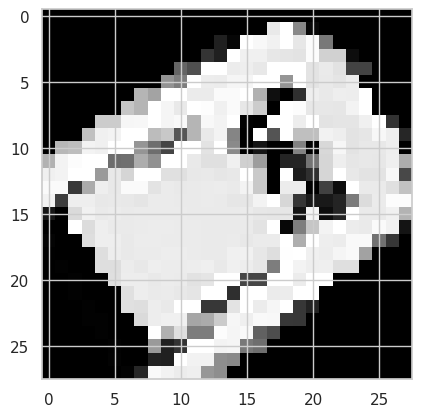

Accuracy: 
Hidden 1: 0.0885000005364418 
Hidden 2: 0.09809999912977219 
Hidden 3: 0.08980000019073486 
FFN:      0.05639999732375145


In [123]:
accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffn = accuracy_calculation_with_affine()
print('Accuracy:',
      '\nHidden 1:', accuracy_first_hidden,
      '\nHidden 2:', accuracy_second_hidden,
      '\nHidden 3:', accuracy_third_hidden,
      '\nFFN:     ', accuracy_ffn)

# Adversarial Attacks
In adversarial attacks, the objective is to alter the input in a way that the model fails to classify it correctly. This implies an intentional increase in the loss associated with that particular input. The loss function, denoted as
J
(
w
,
x
,
y
)
J(w,x,y), typically depends on the model parameters (
w
w), the input data (
x
x), and the corresponding output or target (
y
y).


When we are training the model, we modify the model's weights based on the value of the gradient of the loss function, using the opposite direction w.r.t. the gradient because we want the loss to decrease. To create an adversarial sample we change two things in this procedure:
1. we modify the input instead of the model's weights;
2. we go in the same direction as the gradient, since we want the loss function to increase.

The adversarial sample will then look like:

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$


Assessing the performance of FFNNs and DBNs across different attack strengths reveals valuable insights into their vulnerabilities and strengths. Robust models exhibit lower misclassification rates or maintain higher accuracy even in the face of stronger attacks. This evaluation of robustness through adversarial attacks serves as a crucial step in pinpointing potential weaknesses, guiding model enhancements, and shaping the implementation of defense mechanisms to counter adversarial threats in image classification systems.



In [124]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [125]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_mnist = dbn_mnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [126]:
#lets take 1 clean sample from the test set
test_image = fashion_test.data[100].reshape(1, 784)
test_image.requires_grad_()

#and classify the clean sample

dbn_with_readout = DBNWithReadOut(dbn_fmnist, [linear1, linear2, linear3], readout_level=2)
attacked_model = dbn_with_readout
model_outputs = attacked_model(test_image)
prediction_clean_dbnwr = labels[torch.argmax(model_outputs)]


In [127]:
## Adversarial attack on the network
epsilon = 0.2 # define strength of the attack
test_image_label = fashion_test.targets[100].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss

perturbed_image = fgsm_attack(test_image, epsilon, image_grad) # image, epsilon, data_grad
perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
prediction_peturbed_dbnwr = labels[int(torch.argmax(model_outputs))]

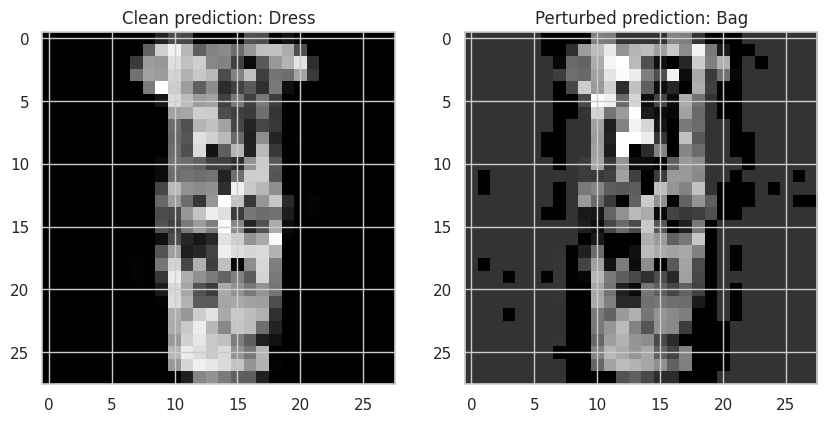

In [128]:
# Plot Clean vs Adversarial sample
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].imshow(test_image.detach().reshape(28,28).to('cpu'), cmap='gray')
axs[0].set_title(f'Clean prediction: {prediction_clean_dbnwr}')
axs[1].imshow(perturbed_image_np.reshape(28,28), cmap='gray')
axs[1].set_title(f'Perturbed prediction: {prediction_peturbed_dbnwr}')
plt.show()

Image is classified as a Shirt, when ground-truth is dress.

# Robustness to adversarial attacks


In [129]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True): # num_steps is the number of top-down reconstructions we do
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28), cmap='gray')
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28), cmap='gray')
            plt.show()

        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28), cmap='gray')
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [130]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST('data/', train=False, download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

Lets see how FFNN performs

In [131]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 24.89%



Finally, we can compare with the read-out trained on the hidden representations of the DBN.

In [132]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 39.16%



  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



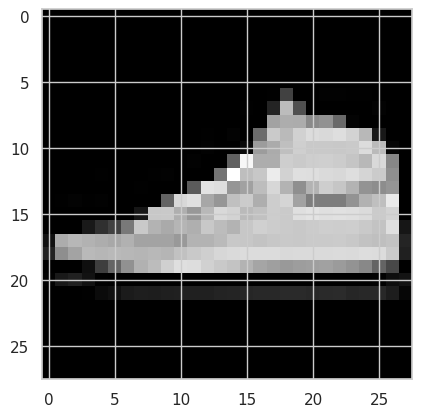


Here's a perturbed sample:



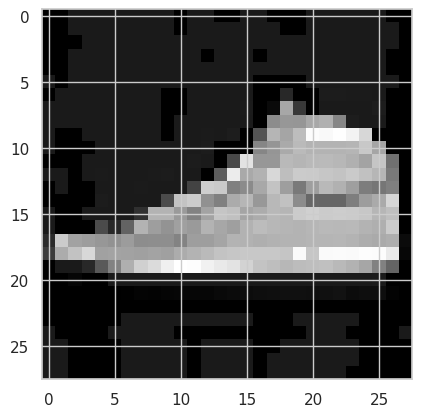


Here's what a 1-steps reconstructed sample looks like:



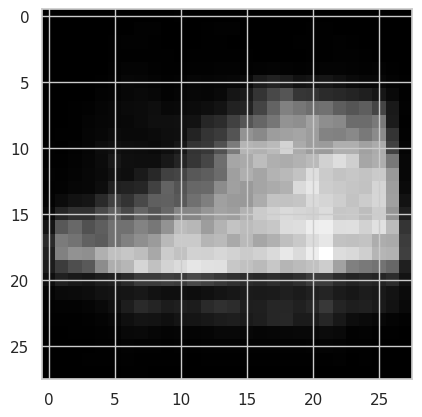


Epsilon: 0.1
Test Accuracy: 35.29%



In [133]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                                          test_loader, epsilon=0.1,
                                                          num_steps=1)


# Atakcs with different Strength


In [134]:
eps_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

def test_epsilon_values(model,n_steps):
  accuracies = list()
  for eps in eps_values:
    acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
    accuracies.append(acc)
  return accuracies



In [135]:
%%capture
acc_ffnn  = test_epsilon_values(ffnn, n_steps=0)
# w/out reconstruction
acc_dbn_0 = test_epsilon_values(dbn_with_readout, n_steps=0)
# with reconstruction
accuracies_dbn_1 = test_epsilon_values(dbn_with_readout, n_steps=1)

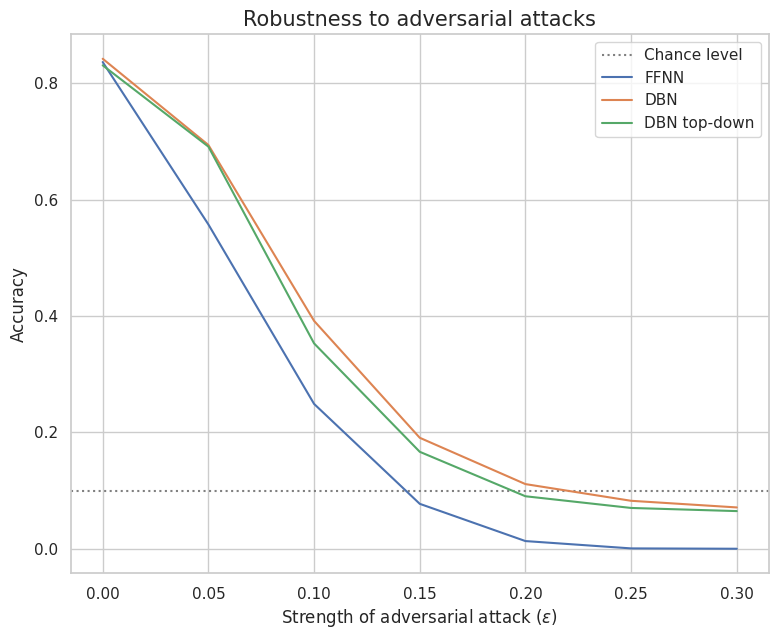

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(eps_values, acc_ffnn)
__ = ax.plot(eps_values, acc_dbn_0)
__ = ax.plot(eps_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

As we can see on plot, Feed Forward Neural Networks are least robust to noise compared to DBN and DBN top-down. But again there is no signnificant performance difference. These models might a bit useful for epsilon values up to 0.05

# Convolutional Neural Networks:

As extra part we are going to implement basic Convolutional Network, even though it is not covered during the course.
Our aim is to see if it is possible to obtain higher results. We are not aiming to go in full details in this part.




In [137]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        return x

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 10

# Load FashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")



# Save the trained model
torch.save(model.state_dict(), "simple_cnn_model.pth")


Epoch 1/10, Loss: 0.4307593756567822
Epoch 2/10, Loss: 0.27371548858882266
Epoch 3/10, Loss: 0.22953247709044897
Epoch 4/10, Loss: 0.19735111398642252
Epoch 5/10, Loss: 0.1757721426779591
Epoch 6/10, Loss: 0.15355783981034782
Epoch 7/10, Loss: 0.13085756331547174
Epoch 8/10, Loss: 0.11369249330801783
Epoch 9/10, Loss: 0.0978986356449105
Epoch 10/10, Loss: 0.08205730645884592


In [138]:
import numpy as np

model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        preds.extend(predicted.cpu().numpy())  # Fix variable name here
        true_labels.extend(labels.cpu().numpy())

accuracy = np.mean(np.array(preds) == np.array(true_labels))
print(f"Accuracy on the test set: {accuracy * 100}%")


Accuracy on the test set: 92.03%


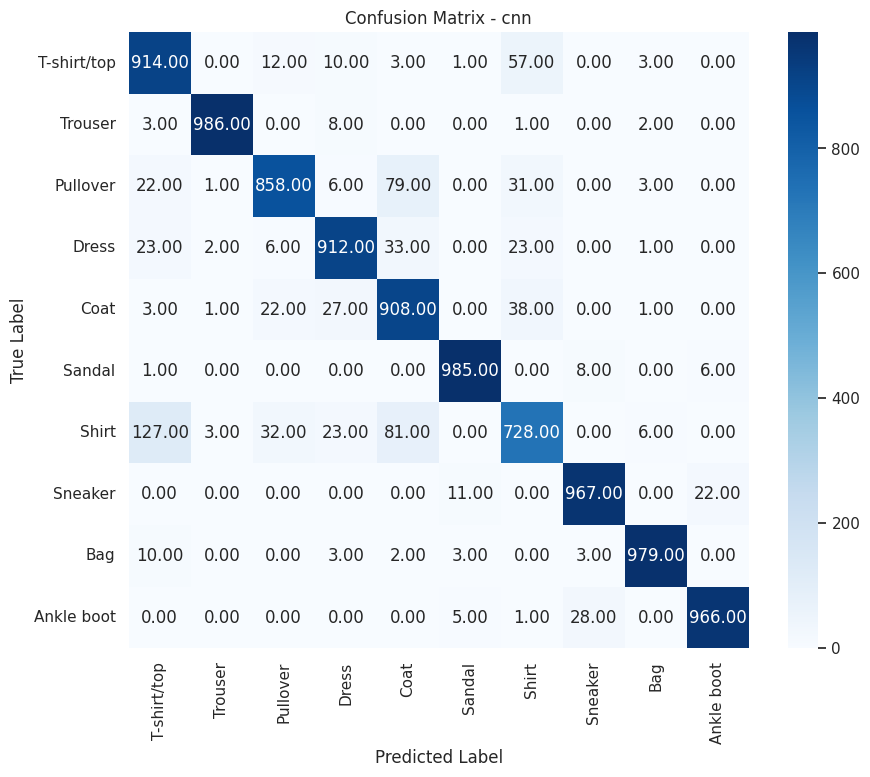

In [139]:
#Last thing lets plot the confussion matrix for the CNN model

pr = {
    'cnn': preds
}

labels = ['T-shirt/top',
          'Trouser',
          'Pullover',
          'Dress',
          'Coat',
          'Sandal',
          'Shirt',
          'Sneaker',
          'Bag',
          'Ankle boot']

plot_confusion_matrices(pr, true_labels, labels)